In [635]:
import numpy as np
import pandas as pd
from scipy.stats import norm

In [553]:
def transmat():
    transmat = np.array([[0.95, 0.05],[0.1, 0.9]])
    return transmat

In [554]:
def emissions():
    emissions = np.array([ np.ones(6)/6, np.ones(6)/10])
    emissions[1][5] = 1/2
    return emissions

In [555]:
t = transmat()
e = emissions()

In [556]:
def viterbi(x, transmat, emissions):
    v_seq = np.zeros((len(x), len(transmat)))
    states = np.zeros((len(x), len(transmat)))
    best_states = np.zeros(len(x),  dtype=int)
    for i in range(len(v_seq)):
        if i == 0:
            v_seq[0] = (1/len(transmat)) * emissions[:,x[i]]
            states[0] = np.array([-1, -1])
            continue
        p = v_seq[i-1] * transmat.T
        states[i] =  np.argmax(p, axis=1)
        v_seq[i] =   emissions[:,x[i]] * np.amax(p, axis = 1)
        
    best_states[-1] = np.argmax(v_seq[-1])
    
    for i in reversed(range(1, len(x))):
        best_states[i-1] = states[i][best_states[i]]
        
    return v_seq, states, best_states
    

# Forward Algorithm

\begin{equation}
\label{eq:bayes}
f_{(k)}(i) =  P(X_{1}....X_{i} |\Pi_{i} = k)
\end{equation}

In [737]:
def forward(x, transmat, emissions):
    f_seq = np.zeros((len(x), len(transmat)))
    for i in range(len(f_seq)):
        if i == 0:
            f_seq[i] =  emissions[:,x[i]] * (1/len(transmat))
            continue
        f_seq[i] = emissions[:,x[i]] * np.matmul(f_seq[i-1], transmat)
        
    P = (1/len(transmat))*sum(f_seq[-1])
        
    return (f_seq, P)

# Backward Algorithm

\begin{equation}
\label{eq:bayes}
B_{(k)}(i) =  P(X_{i+1}....X_{L} |\Pi_{i} = k)
\end{equation}

In [558]:
def backward(x, transmat, emissions):
    b_seq = np.zeros((len(x), len(transmat)))
    for i in reversed(range(len(b_seq))):
        if i == len(b_seq) -1:
            b_seq[i] =  (1/len(transmat))*np.ones(len(transmat))
            continue
        b_seq[i] = np.matmul(emissions[:,x[i+1]] * b_seq[i+1],  transmat.T)
    
    P = (1/len(transmat))*sum(emissions[:,x[0]] * b_seq[0])
    return (b_seq, P)

In [726]:
x = np.array([1,0, 5, 1,5, 5,3, 5, 5, 1, 2,3, 4, 5, 5, 5,0, 2, 3, 4 ,5, 5, 5, 1, 5, 5, 4, 5, 1, 2, 0, 4, 5, 1, 5, 1, 0,1, 1, 2, 3, 4, 5, 5, 2, 0, 2, 3, 1, 1, 5, 5, 5, 5,5 ,5
             ,5,3,5,5,5,0,5,5,5,5,5,2,5,5,2, 1,5,5,5,0,5,1,2,3,1,1,0,1,1,0,1,1,1,1,2,2,2,2,2,2,4,3,2,3,4,1,5,1,5,0,2,3,4,5])

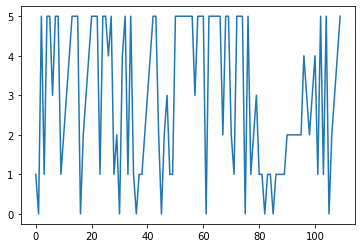

In [727]:
plt.plot(range(len(x)),x)

In [560]:
v, states, path = viterbi(x, t, e)

In [561]:
f, P1 = forward(x,t,e)

In [562]:
b, P2 = backward(x,t,e)

# Let's plot posterior probabilities

\begin{equation}
\label{eq:bayes}
P(\pi(i) = k|\textbf{X}) =  \frac{P(X_{1}....X_{i} |\Pi_{i} = k) P(X_{i+1}....X_{L} |\Pi_{i} = k)}{P(\textbf{X})} 
\end{equation}

## Which is just:

\begin{equation}
\label{eq:bayes}
P(\pi(i) = k|\textbf{X}) =  \frac{f_{(k)}(i) B_{(k)}(i)}{P(\textbf{X})} 
\end{equation}

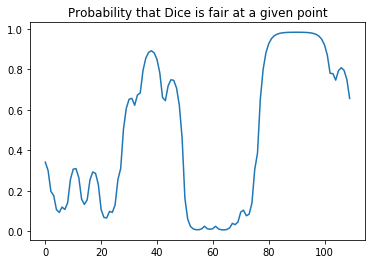

In [730]:
import matplotlib.pyplot as plt
plt.title('Probability that Dice is fair at a given point')
plt.plot(f[:, 0]*b[:,0]/P1)
plt.show()


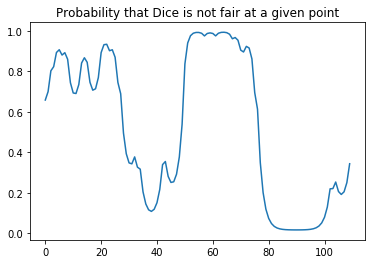

In [732]:
import matplotlib.pyplot as plt
plt.title('Probability that Dice is not fair at a given point')
plt.plot(f[:, 1]*b[:,1]/P1)



plt.show()

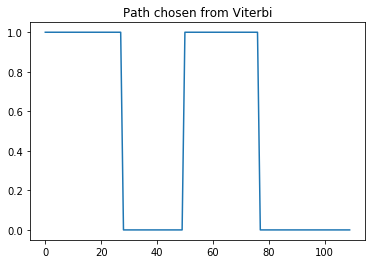

In [733]:
plt.title('Path chosen from Viterbi')
plt.plot(path)

In [577]:
file_name = '/pollard/home/lchumpitaz/Hi-C/GM12878_inSitu_MboI.hg19.mapq_30_1.csv'

In [578]:
df = pd.read_csv(file_name)

In [582]:
filtered_df= df[df['E1'] == df['E1']]

In [589]:
loc_eig = filtered_df[filtered_df['chrom'] == 'chr1']

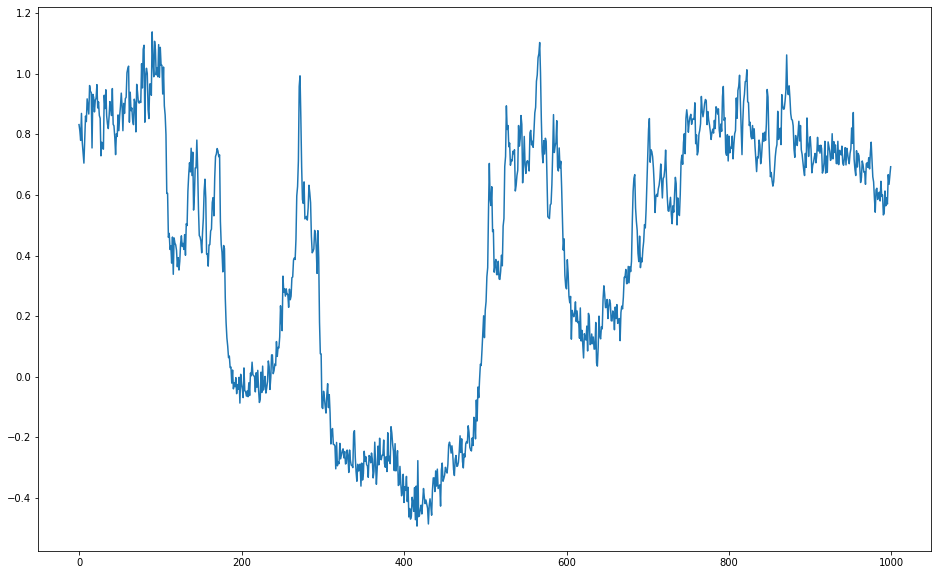

In [619]:
fig = plt.figure(figsize=(16, 10)) 
data = loc_eig['E1'].values
plt.plot(np.round(data, 3)[0:1000])

In [713]:
w_data = np.round(data, 2)
len(w_data)

21681

In [714]:
middle = np.percentile(w_data, [25, 75])

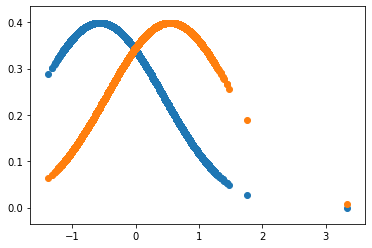

In [715]:
rv1 = norm(loc = middle[0], scale = 1.0)
rv2 = norm(loc = middle[1], scale = 1.0)

x = np.arange(-10, 10, .01)

#plot the pdfs of these normal distributions 
plt.scatter( w_data, rv1.pdf(w_data))
plt.scatter(w_data, rv2.pdf(w_data))

In [719]:
rv2.pdf(w_data)

array([0.38251457, 0.38466266, 0.38761662, ..., 0.37903053, 0.38138782,
       0.37524035])